# Kaggle: Dogs vs Cats

![image](https://user-images.githubusercontent.com/59414764/117839690-6c8e7700-b2b6-11eb-8b69-ea8e3727280e.png)


- 문제 분석: test셋의 index 이름으로 된 jpg형식 이미지를 {1:'dog', 2:'cat'}으로 분류하는 문제다.
- 학습 데이터 분석: 데이터는 모두 jpg형식으로 된 이미지이며, 분류 label은 이미지 파일 이름에 적용되어 있다. ex) 'dog.24.jpg'

In [1]:
import cv2
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.image as pltimg

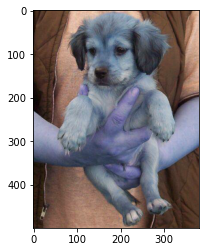

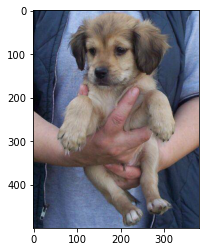

In [2]:
data_dir = "/Users/ibird/ML_Data/dogs-vs-cats/"
train_dir = data_dir + "train/"
test_dir = data_dir + "test1/"

dataset = [f for f in os.listdir(train_dir)]

# for test
img_cv = cv2.imread(train_dir+dataset[0])
img_mpl = pltimg.imread(train_dir+dataset[0])
plt.imshow(img_cv)
plt.show()
plt.imshow(img_mpl)
plt.show()

matplotlib, opencv2어떤 모듈을 쓰는 게 좋을까? 일단 두가지가 색이 다른 이유는 무엇일까? 아마 픽셀 데이터를 받아오고 rgb값을 배치하는 순서가 달라서일 듯하다.

In [3]:
print(img_cv[0][0])
print(img_mpl[0][0])

[44 31 23]
[23 31 44]


첫번째 픽셀을 확인하면 역시 rgb값 배치가 다른 것을 볼 수 있다. 일단 rgb배열 위치는 결과에 영향을 주지 않을 것으로 생각된다. (CNN을 이용해 분류하는 데는 영향을 미치지 않기 때문. 픽셀간의 위치 관계, 픽셀의 크기가 영향을 줄 것으로 생각된다. CNN원리상)  
일단, opencv의 기능이 많고 이용할 기회가 있을 것 같으므로 opencv를 사용하도록 하겠다. 대신 imshow를 위해 전처리가 필요하다.

In [4]:
print(len(img_cv), len(img_cv[0]))

500 380


In [5]:
# opencv의 imshow를 위한 함수
def cv2_imshow(cv_img):
    from itertools import product
    
    ret = cv_img.copy()
    for j, i in product(range(len(cv_img)), range(len(cv_img[0]))):
        ret[j][i][0], ret[j][i][2] = ret[j][i][2], ret[j][i][0]
    
    plt.imshow(ret)
    plt.show()

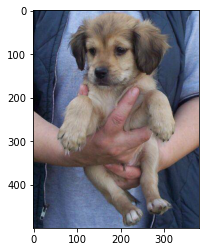

In [6]:
cv2_imshow(img_cv)

굿! 원하던 그림이 출력된다.

이제 데이터를 분류하고 reshape한 뒤에 CNN에 넣어보자.
후에 피드백으로 전처리를 어떻게 할 것인지 판단!

학습데이터와 검증데이터를 분류할 때, stratified sampling을 이용하자

먼저 데이터를 한번만 더 살펴보자. 강아지 그림은 몇개있는지, 고양이는 몇개있는지. 총 몇개인지 (노이즈가 큰 데이터는 무엇인지)

In [7]:
# 타겟셋을 만든다
target = [f.split('.')[0] for f in dataset]
target[:10]

['dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog']

In [8]:
dog_dataset = []
cat_dataset = []
for f in dataset:
    if f[:3]=='dog':
        dog_dataset.append(f)
    elif f[:3] == 'cat':
        cat_dataset.append(f)

print("총 데이터셋 크기: " ,len(dataset) , ", 강아지: ", len(dog_dataset), " 고양이: ",len(cat_dataset))

총 데이터셋 크기:  25000 , 강아지:  12500  고양이:  12500


In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

train_data, train_target, test_data, test_target = [], [], [], []
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=99)
for train_idx, test_idx in split.split(dataset, target):
    for i in train_idx:
        train_data.append(dataset[i])
        train_target.append(1 if dataset[i][:3]=='dog' else 0)
    for i in test_idx:
        test_data.append(dataset[i])
        test_target.append(1 if dataset[i][:3]=='dog' else 0)

print(len(train_data), len(test_data))

17500 7500


In [10]:
#list(zip(train_data, train_target))[:10]

In [11]:
train_imgs = np.array([cv2.resize(cv2.imread(train_dir + f), dsize=(360,360), interpolation=cv2.INTER_LINEAR) for f in train_data], dtype=object)
#test_imgs = np.array([cv2.resize(cv2.imread(train_dir + f), dsize=(360,360), interpolation=cv2.INTER_LINEAR) for f in test_data], dtype=object)

데이터를 학습 데이터셋과 테스트 데이터셋으로 stratified sampling을 통해 나누고, np행렬로 바꿔 저장했다.
이제 모델에 넣을 이미지 크기를 일치시켜야한다. opencv의 resize함수를 쓰면되지만은, 이미지 크기를 몇으로 하지??  
가장 작은 이미지 사이즈에 맞춰야하나, 또는 가장 큰 사이즈? 또는 평균사이즈? opencv의 resize는 선형보간법을 이용한다. 픽셀이야 더 커져도 괜찮을 것 같지만, 픽셀(feature)를 잃으면 더 성능이 안 좋아지지 않을까??

[참고](https://i-am-eden.tistory.com/4)를 통해 FCN을 사용하면 된다는 것을 알았다.

일단... 더 조사해보고 싶지만, 결과를 내보기 위해 opencv의 resize함수를 이용하여 입력 이미지 크기로 조정해보겠다. opencv의 resize의 원리는 선형보간법을 이용한 것이다. 이미지의 크기 기준은 1.가장 작은 가로, 세로 크기  2.가장 큰 가로, 세로 크기  3.평균 가로, 세로 크기로 지정할 것이다.

In [12]:
def resize(imgs, mode='min', img_size=(0, 0)):
    mode_accept = {'min':cv2.INTER_AREA, 'max':cv2.INTER_CUBIC, 'avg':cv2.INTER_LINEAR}
    # [height, width]
    size_accept = {'min':(min(map(lambda x: len(x[0]), train_imgs)), min(map(len, train_imgs))),
                   'max':(max(map(lambda x: len(x[0]), train_imgs)), max(map(len, train_imgs))),
                   'avg':(int(np.mean(list(map(lambda x: len(x[0]), train_imgs)))), int(np.mean(list(map(len, train_imgs))))),
                   'custom':img_size}
    transform = np.array(list(map(lambda x: cv2.resize(x, dsize=size_accept[mode], interpolation=mode_accept[mode]), imgs)))
    return transform

In [13]:
#avg_train_imgs = resize(train_imgs, 'avg')
avg_train_imgs = train_imgs

In [14]:
img_height, img_width = len(avg_train_imgs[0]), len(avg_train_imgs[0][0])

In [15]:
img_height, img_width

(360, 360)

In [16]:
train_scaled = avg_train_imgs.reshape(-1, img_height, img_width, 3)

In [17]:
def model_cnn(new_layer = None):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size=3, strides=(1,1), activation='relu', padding='same', input_shape=(img_height, img_width,3)))
    model.add(keras.layers.MaxPool2D(2))
    model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(keras.layers.MaxPool2D(2))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

model = model_cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 360, 360, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 180, 180, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 518400)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               51840100  
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

In [18]:
train_target = np.array(train_target)

이 부분에서 계속 커널이 죽는다...

In [19]:
Adam = keras.optimizers.Adam(learning_rate= 0.001)
model.compile(optimizer=Adam, loss='sparse_categorical_crossentropy', metrics='accuracy')

#checkpoint = keras.callbacks.ModelCheckpoint('best-cnn-model.h5')
#early_stopping = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

#score = model.fit(train_scaled, train_target, epochs=20)

In [ ]:
score = model.fit(train_scaled, train_target, epochs=20)